## Visualization Demo

This demonstration of visualizatioin uses the [PyWWT package](https://pywwt.readthedocs.io/en/stable/)  as well as catalog access and image retrieval with [PyVO](https://pyvo.readthedocs.io/en/latest/).  For more about how to use the latter, see the [python notebooks](https://heasarc.gsfc.nasa.gov/navo/summary/python.html) developed by the NASA archives.  

In [1]:
## Two ways to do this.  If you open the WWT App through 
##  the JupyterLab Launcher, here's how to connect to it:
#from pywwt.jupyter import connect_to_app
#wwt = connect_to_app()
## Or you can open the widget in this notebook
import warnings
from astropy.io import fits
from astropy.utils.data import download_file
from astropy import units as u

import matplotlib.pyplot as plt


import astropy.coordinates as coord
import pyvo as vo
warnings.filterwarnings('ignore', '.*Unknown element mirrorURL.*', vo.utils.xml.elements.UnknownElementWarning)

from pywwt.jupyter import WWTJupyterWidget
wwt = WWTJupyterWidget()
wwt

WWTJupyterWidget(layout=Layout(align_self='stretch', height='400px'))

The widget opens up with a default view. Let's set the background to Halpha emission and the field of view to center on the crab.  You can do the pan and zoom with your mouse or with the command below.  

In [2]:
wwt.background = 'Hydrogen Alpha Full Sky Map' 
coords=coord.SkyCoord.from_name('crab')
from astropy import units as u
wwt.center_on_coordinates(coords,fov=5*u.arcmin)


Now we're going to look for Chandra observations of the crab using a query to the HEASARC catalog service.  Let's just get the top 10 deepest exposures:

In [3]:
#  Get the TAP service from the Registry.  
heasarc=vo.regsearch(servicetype='tap',keywords=['heasarc'])[0]
query=f"""SELECT top 10 * 
    FROM chanmaster
    WHERE 1=CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS', {coords.ra.deg}, {coords.dec.deg}, 1))  
 """

results=heasarc.search(query)
results.to_table()

__row,obsid,status,name,ra,dec,lii,bii,time,detector,grating,exposure,type,pi,cycle,proposal,public_date,sequence_number,data_mode,category,class,__x_ra_dec,__y_ra_dec,__z_ra_dec
,,,,deg,deg,deg,deg,mjd,,,s,,,,,mjd,,,,,,,
object,int32,object,object,float64,float64,float64,float64,float64,object,object,float64,object,object,int16,object,int32,int32,object,object,int16,float64,float64,float64
13188,759,archived,CRAB PULSAR,83.63333,22.01444,184.55762,-5.78420,51576.4384953704,HRC-S,LETG,45430,GO,Weisskopf,1,01500806,51998,500055,OBS00759,"SN, SNR AND ISOLATED NS",3200,0.921371678358821,0.102805705829355,0.374840255531842
13189,758,archived,CRAB PULSAR,83.63333,22.01444,184.55762,-5.78420,51574.0518402778,HRC-S,LETG,100220,GO,Weisskopf,1,01500806,52026,500054,OBS00758,"SN, SNR AND ISOLATED NS",3200,0.921371678358821,0.102805705829355,0.374840255531842
13190,9765,archived,CRAB PULSAR,83.63333,22.01444,184.55762,-5.78420,54487.6647800926,HRC-S,LETG,96170,GO,Weisskopf,1,01500806,54856,501013,S_TIMING,"SN, SNR AND ISOLATED NS",3200,0.921371678358821,0.102805705829355,0.374840255531842
13191,4607,archived,Crab Nebula,83.63333,22.01444,184.55762,-5.78420,53031.0498032407,ACIS-S,NONE,37740,GO,Seward,5,05500128,53399,500432,TE_00662,"SN, SNR AND ISOLATED NS",3200,0.921371678358821,0.102805705829355,0.374840255531842
13192,9764,archived,CRAB PULSAR,83.63333,22.01444,184.55762,-5.78420,54461.479224537,HRC-S,LETG,3750,GO,Weisskopf,1,01500806,54828,501012,S_TIMING,"SN, SNR AND ISOLATED NS",3200,0.921371678358821,0.102805705829355,0.374840255531842
13193,8548,archived,CRAB PULSAR,83.63333,22.01444,184.55762,-5.78420,54369.4925115741,HRC-S,LETG,9130,GO,Weisskopf,1,01500806,54737,500823,S_TIMING,"SN, SNR AND ISOLATED NS",3200,0.921371678358821,0.102805705829355,0.374840255531842
13194,3831,archived,CRAB PULSAR,83.63333,22.01444,184.55762,-5.78420,52908.8219791667,HRC-S,LETG,8830,GTO,Predehl,4,04500034,53277,500310,OBS03831,"SN, SNR AND ISOLATED NS",3200,0.921371678358821,0.102805705829355,0.374840255531842
13195,7587,archived,Crab Pulsar,83.63292,22.01447,184.55739,-5.78450,54134.4159375,ACIS-S,HETG,46180500,GTO,Canizares,8,08500060,54502,500719,TE_0077C,"SN, SNR AND ISOLATED NS",3200,0.92137074761761,0.10281227725869,0.374840740954673


Now that we have a list of observations, we can see what data products are available for them using the getdatalink() function look for a FITS image to display.  Each observation has a list of things you can retrieve, some of which are further links to browse deeper into the HEASARC archive.  This function below recurses down a given observation to find products of a given type:

In [4]:
def linkwalker( result, level, keyword=None, ctype=None,returnFirst=True):
    try:
        result2=result.getdatalink()
        if keyword is None and ctype is None:
            print(result2.to_table()['description','content_type'])
        else:
            for i,r in enumerate(result2.to_table()):
                if keyword is not None and keyword.lower() not in r['description'].lower():
                    continue 
                if ctype is not None and ctype.lower() not in r['content_type'].lower():
                    continue
                print(f"Found match in level {level}")
                return(result2[i])
    except Exception as e:
        print("Exception {}".format(e))
        return
    for link in [l for l in result2 if "datalink" in l.content_type]:
        x=linkwalker(link, level+1, keyword,ctype)
        if x is not None:
            return(x)
    return

Not all of these observations have a FITS image available.  You can browse them, or loop over them, as you wish.  You'll find that the 9th row (counting from 0) has a decent looking image:

Found match in level 2


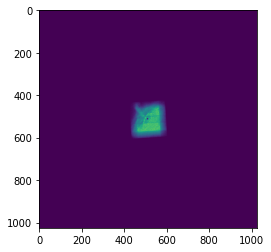

In [5]:
#  This returns the (first) Record corresponding to the 
#   Center Image in FITS for the given observation:
r=linkwalker(results[9],0,keyword='Center',ctype='fits')
hdu_list = fits.open(r.getdataurl())
plt.imshow(hdu_list[0].data)

In [6]:
hdu_list[0].data.shape

(1025, 1024)

Let's just cut out the central region:

In [7]:
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy import units as u
w = WCS(hdu_list[0].header, hdu_list)
cutout = Cutout2D(hdu_list[0].data, coords, (2*u.arcmin,2*u.arcmin), wcs=w)

Set MJD-END to 51581.474317 from DATE-END'. [astropy.wcs.wcs]


<AxesSubplot:>

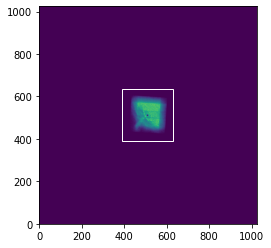

In [8]:
plt.imshow(hdu_list[0].data,origin='lower')
cutout.plot_on_original(color='white')

So now let's add it to the viewing widget on top of the background Halpha emission:

In [9]:
layer2= wwt.layers.add_image_layer(image=(cutout.data,cutout.wcs))
layer2.opacity=0.5